# Import des libraries

In [35]:
import numpy as np
import pandas as pd
import itertools
import re
import time
import matplotlib.pyplot as plt
import psutil

# Algorithme Grite et Sgrite.

In [36]:
def generateMatrixOfSingle(dataset, attribut, sign='plus'):
        a = list()
        f_list = list()
        for i in range(len(dataset[attribut])):
            for j in range(len(dataset[attribut])):
                if i == j :
                    a.append(0)
                else:
                    if(dataset[attribut][j] >= dataset[attribut][i]):
                        a.append(1)
                    else:
                        a.append(0)
            f_list.append(a)
            a = list()

        f_list = np.array(f_list)
        for i in range(f_list.shape[0]):
            for j in range(f_list.shape[1]):
                if(f_list[i][j] == 1):
                    f_list[j][i] = 0
        return np.array(f_list)

def generateMatrixOfSingleinf(dataset, attribut, sign='moin'):
        a = list()
        f_list = list()
        for i in range(len(dataset[attribut])):
            for j in range(len(dataset[attribut])):
                if i == j :
                    a.append(0)
                else:
                    if(dataset[attribut][j] <= dataset[attribut][i]):
                        a.append(1)
                    else:
                        a.append(0)
            f_list.append(a)
            a = list()

        f_list = np.array(f_list)
        for i in range(f_list.shape[0]):
            for j in range(f_list.shape[1]):
                if(f_list[i][j] == 1):
                    f_list[j][i] = 0
        return np.array(f_list)

In [37]:
def purify(list_set_string):
    dechet = []
    not_complementrary = []
    for elm in list_set_string:
        p = list(map(lambda x: x.replace('+','').replace('-',''),list(elm)))
        if len(p) != len(set(p)):
            dechet.append(elm)
    for de in dechet:
        list_set_string.remove(de)

In [38]:
def generatPatern(dataset, minsup):
    pattern = dict()
    attributs = list(dataset.columns)
    for i in attributs :
        matrix_plus = generateMatrixOfSingle(dataset,i, sign='plus')
        matrix_moin = generateMatrixOfSingleinf(dataset,i,'moin')
        sup_plus = computeSupportSgrite(matrix_plus, minsup)
        sup_moin = computeSupportSgrite(matrix_moin)
        if(sup_plus >= minsup):
            pattern[i+'+'] = (matrix_plus, sup_plus)

        if(sup_moin >= minsup):
            pattern[i+'-'] = (matrix_moin, sup_moin)
    return pattern

def generatPatern__(dataset, minsup):
    pattern = dict()
    attributs = list(dataset.columns)
    for i in attributs :
        matrix_plus = generateMatrixOfSingle(dataset,i,'plus')
        matrix_moin = generateMatrixOfSingle(dataset,i,'moin')
        sup_plus = applySupportGrite(matrix_plus)
        sup_moin = applySupportGrite(matrix_moin)
        if(sup_plus >= minsup):
            pattern[i+'+'] = (matrix_plus, sup_plus)

        if(sup_moin >= minsup):
            pattern[i+'-'] = (matrix_moin, sup_moin)
    return pattern

In [39]:
def findsubsets(s, n):
    return list(map(set,itertools.combinations(s, n)))

In [40]:
def reunion(list_set):
    if len(list_set) <= 1: return list_set
    else :
      lest_init = set()
      for i in range(len(list_set)):
        lest_init = lest_init.union(list_set[i])
    return lest_init

In [41]:
def print_pattern_mined(patterns):
    for key, value in zip(patterns.keys(),patterns.values()):
        print(f"{key} ({value[1]}) ({value[2]})")
    print(f"{len(patterns)} patterns mined")

    return len(patterns)

In [42]:
def parents(son, matrix):
    element_parent = list()
    for line in range(matrix.shape[0]):
        if(matrix[line][son] == 1):
            element_parent.append(line)
    return element_parent

In [43]:
def getSongs(father, matrix):
    sons = list()
    for col in range(len(matrix[father])):
        if(matrix[father][col] == 1):
            sons.append(col)
    return sons

In [44]:
def getLeafs(matrix):
    leafs = list()
    for line_index in range(matrix.shape[0]):
        if sum(matrix[line_index]) == 0:
            leafs.append(line_index)
    return leafs

In [45]:
def produit(terme):
    if len(terme) == 0:
        return 1
    else:
        return terme[0] * produit(terme[1::])

In [46]:
def somme(terme):
    if len(terme) == 0:
        return 1
    else:
        return terme[0] + somme(terme[1::])

In [47]:
def computeSupportSgrite(matrix, minsup=2):
    memory = list(map(lambda x : -1, list(np.arange(matrix.shape[1]))))
    memoryChaine = list(map(lambda x : [], list(np.arange(matrix.shape[1]))))
    stack = getLeafs(matrix)
    for i in stack:
        memory[i] = 1

    while(len(stack) != 0):
        thing = stack.pop()
        thing_parents = parents(thing, matrix)

        for parent in thing_parents :
            if memory[parent] < memory[thing] + 1 :
                memory[parent] = memory[thing] + 1
                if(parent not in stack):
                    stack.append(parent)


    return (max(memory))


In [48]:
def computeSupportGrite(begin, memory, matrix):
    sons = getSongs(begin, matrix)
    if len(sons) == 0:
        memory[begin] = 1
    else:
        for son in sons:
            if memory[son] == -1:
                computeSupportGrite(son, memory, matrix)
        for son in sons :
            my_parents = parents(son,matrix)
            for pere in my_parents:
                memory[pere] = max(memory[pere], memory[son] + 1)

def applySupportGrite(matrix,minsup=2):
    tel_me=[]
    for i in range(matrix.shape[0]):
       if(len(parents(i, matrix)) == 0 ):
          memory = list(map(lambda x : -1, list(np.arange(matrix.shape[1]))))
          computeSupportGrite(i, memory, matrix)
          tel_me.append(max(memory))

    return (max(tel_me))

In [49]:
def formMatrix(dataset, elem):
    if "+" in elem :
        elem = elem.replace("+","")
        return generateMatrixOfSingle(dataset, elem, sign='plus')
    elif("-" in elem):
        elem = elem.replace("-","")
        return generateMatrixOfSingle(dataset, elem, sign='moin')

#key example : A+,C+,D+
def decompose_keys(dataset, key):
    key_table = key.split(",")
    result = 1
    for elem in key_table:
        result = result * formMatrix(dataset, elem)


    return result

In [50]:
def generatItemsetPatternGrite(dataset, minsup):
    frequent_pattern = generatPatern(dataset, minsup)
    new_patterns = dict()
    frequents = set(frequent_pattern.keys())
    for num in range(2, len(dataset.columns) + 1):
        frequents = findsubsets(frequents, num)
        
        for i in frequents :
            str = ' , '.join(e for e in list(i))


            matrix = produit(list(map(lambda x:frequent_pattern[x][0], list(i))))
            support = applySupportGrite(matrix)

            if(support >= minsup):
                new_patterns[str] = (matrix,support)


            support = applySupportGrite(matrix)

            if(support >= minsup):
                        new_patterns[str] = (matrix,support)


        if(len(new_patterns) == 0): break

        frequent_pattern.update(new_patterns)
        frequents = reunion(list(map(lambda x:set(re.split(' , ',x)), list(new_patterns.keys()))))
        new_patterns = dict()

    return frequent_pattern

In [51]:
def generatItemsetPatternMotifGrite(dataset, minsup):
    frequent_pattern = generatPatern(dataset, minsup)
    new_patterns = dict()
    nbr = 0
    frequents = set(frequent_pattern.keys())
    for num in range(2, len(dataset.columns) + 1):
        frequents = findsubsets(frequents, num)
   
        for i in frequents :
            str = ' , '.join(e for e in list(i))

            matrix = produit(list(map(lambda x:frequent_pattern[x][0], list(i))))
            support = applySupportGrite(matrix)

            if(support[0] >= minsup):
                new_patterns[str] = (matrix,support,support)

            if np.sum(matrix) > minsup * (minsup - 1)/2:
                support = applySupportGrite(matrix)

                if(support >= minsup):
                        new_patterns[str] = (matrix,support)
            else:
                nbr += 1

        if(len(new_patterns) == 0): break

        frequent_pattern.update(new_patterns)
        frequents = reunion(list(map(lambda x:set(re.split(' , ',x)), list(new_patterns.keys()))))
        new_patterns = dict()

    return frequent_pattern, nbr

In [52]:
from tqdm import tqdm

In [53]:
def generatItemsetPattern(dataset, minsup, decision=True):
    frequent_pattern = generatPatern(dataset, minsup)
    new_patterns = dict()
    frequents = set(frequent_pattern.keys())
    for num in range(2, len(dataset.columns) + 1):
        frequents = findsubsets(frequents, num)

        for i in frequents :
            str = ' , '.join(e for e in list(i))
            if decision :
                if num % 2 == 0:


                    matrix = produit(list(map(lambda x:frequent_pattern[x][0], list(i))))
                    support = computeSupportSgrite(matrix, minsup)

                    if(support[0] >= minsup):
                        new_patterns[str] = (matrix,support[0],support[1])
                else:

                    matrix = somme(list(map(lambda x:frequent_pattern[x][0], list(i))))

                    for i in range(matrix.shape[0]):
                        for j in range(matrix.shape[1]):
                            matrix[i][j] = matrix[i][j]//matrix[i][j]

                    for i in range(matrix.shape[0]):
                        for j in range(matrix.shape[1]):
                            if matrix[i][j] == 1:
                                matrix[j][i] = 0

                    # print(matrix)
                    support = computeSupportSgrite(matrix, minsup)


                    if(support[0] >= minsup):
                        new_patterns[str] = (matrix,support[0],support[1])
            else :

                        matrix = produit(list(map(lambda x:frequent_pattern[x][0], list(i))))

                        support = computeSupportSgrite(matrix, minsup)

                        if(support[0] >= minsup):
                                  new_patterns[str] = (matrix,support[0],support[1])



                        # print(matrix)
                        support = computeSupportSgrite(matrix, minsup)


                        if(support[0] >= minsup):
                            new_patterns[str] = (matrix,support[0],support[1])




        if(len(new_patterns) == 0): break

        frequent_pattern.update(new_patterns)
        frequents = reunion(list(map(lambda x:set(re.split(' , ',x)), list(new_patterns.keys()))))
        new_patterns = dict()

    return frequent_pattern


In [22]:
def generatItemsetPatternModif(dataset, minsup, decision=True):
    frequent_pattern = generatPatern(dataset, minsup)
    new_patterns = dict()
    nbr = 0
    frequents = set(frequent_pattern.keys())
    for num in range(2, len(dataset.columns) + 1):
        frequents = findsubsets(frequents, num)

        purify(frequents)

        for i in frequents :
            str = ' , '.join(e for e in list(i))
            if decision :
                if num % 2 == 0:


                    matrix = produit(list(map(lambda x:frequent_pattern[x][0], list(i))))
                    support = computeSupportSgrite(matrix, minsup)

                    if(support[0] >= minsup):
                        new_patterns[str] = (matrix,support[0],support[1])
                else:

                    matrix = somme(list(map(lambda x:frequent_pattern[x][0], list(i))))

                    for i in range(matrix.shape[0]):
                        for j in range(matrix.shape[1]):
                            matrix[i][j] = matrix[i][j]//matrix[i][j]

                    for i in range(matrix.shape[0]):
                        for j in range(matrix.shape[1]):
                            if matrix[i][j] == 1:
                                matrix[j][i] = 0

                    # print(matrix)
                    support = computeSupportSgrite(matrix, minsup)

                    if(support[0] >= minsup):
                        new_patterns[str] = (matrix,support[0],support[1])
            else :

                        matrix = produit(list(map(lambda x:frequent_pattern[x][0], list(i))))
                        if np.sum(matrix) > minsup * (minsup - 1)/2:
                            support = computeSupportSgrite(matrix, minsup)

                            if(support[0] >= minsup):
                                  new_patterns[str] = (matrix,support[0],support[1])
                        else:
                            nbr += 1



                        # print(matrix)
                        support = computeSupportSgrite(matrix, minsup)


                        if(support[0] >= minsup):
                            new_patterns[str] = (matrix,support[0],support[1])

        if(len(new_patterns) == 0): break

        frequent_pattern.update(new_patterns)
        frequents = reunion(list(map(lambda x:set(re.split(' , ',x)), list(new_patterns.keys()))))
        new_patterns = dict()

    return frequent_pattern, nbr


In [23]:
def complementary(key1, key2):
    str1 = key1
    str2 = key2
    if(len(str1) == len(str2)):
        str2 = str2.replace('+', '0').replace('-', '+').replace('0', '-')
        liste = list(map(lambda s: ' , '.join(e for e in set(s)),list(itertools.permutations(set(str2.split(' , '))))))
        if str1 in liste :
            return True
    return False

def delete_complement(patterns):
    pattern_clean = dict()
    pattern_keys = list(patterns.keys())
    keys_delete = []

    for i in range(len(patterns)):
        for j in range(i+1,len(patterns)):
            if complementary(pattern_keys[i], pattern_keys[j]) :
                if '-' in pattern_keys[i] :
                    keys_delete.append(pattern_keys[i])
                else:
                    keys_delete.append(pattern_keys[j])
                break
    for key, value in patterns.items():
        if key not in keys_delete:
            pattern_clean[key] = value

    return pattern_clean

#  chargement des dataset

In [24]:
datasets = ['datasets/dataset.csv']

In [25]:
les_dataset = list(map(lambda x: pd.read_csv(x, sep=' '), datasets))

In [26]:
les_dataset[0]

,1,2,3,4,5,7,8,9,10,11
0,67108,522,257,736,5114,2151,1589,14,23,71
1,18676,620,325,817,6172,2450,1909,17,22,79
2,10051,746,390,858,8049,2053,1737,5,18,62
3,7091,529,291,780,5430,1695,1229,14,13,50
4,56857,542,312,1068,4620,1743,1104,7,15,46
...,...,...,...,...,...,...,...,...,...,...
195,25006,517,244,905,5107,2102,1469,21,23,129
196,35618,532,257,803,5310,2519,1887,20,13,153
197,41751,546,332,724,6628,2926,2535,11,21,171
198,29774,685,376,736,7940,2484,2191,23,24,235


In [27]:
from tqdm import tqdm

In [56]:
elem = generatItemsetPatternGrite(les_dataset[0], 70)
len(elem) #10 - 230 #20 - 42 #25 - 35, 50-20,50-42

20

In [112]:
#Grite =>

# (100, 10) -> (50 - 22)
# (100, 20) -> (50 - 43)
# (100, 30) -> (50 - 63)
# (100, 40) -> (50 - 84)
# (100, 50) -> (50 - 105)

In [28]:
items = [10, 20, 30, 40, 50]
nbr_p = [22, 43, 63, 83, 105]
minsup = 50

In [29]:
items1 = [10, 20, 30, 40, 50]
nbr_p1 = np.array([772, 1551, 2200, 3019, 4500])/100
minsup1 = 1225

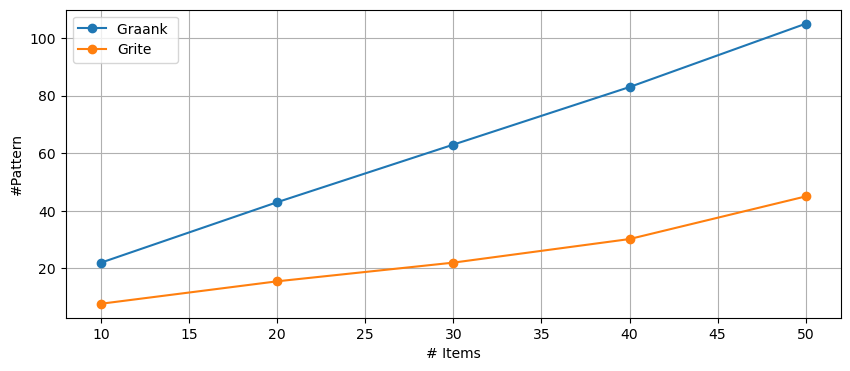

In [29]:
plt.figure(figsize=(10, 4))
plt.grid('--')
plt.xlabel("# Items")
plt.ylabel("#Pattern")
plt.plot(items, nbr_p,items1, nbr_p1, marker='o')
plt.legend(["Graank ","Grite"])
plt.show()

In [44]:
items2 = [10, 20, 30, 40, 50]
nbr_p2 = [20, 40, 94, 121, 140]
nbr_p3 = np.array([8713, 13426, 17887, 22403, 25658])/100
minsup = 50

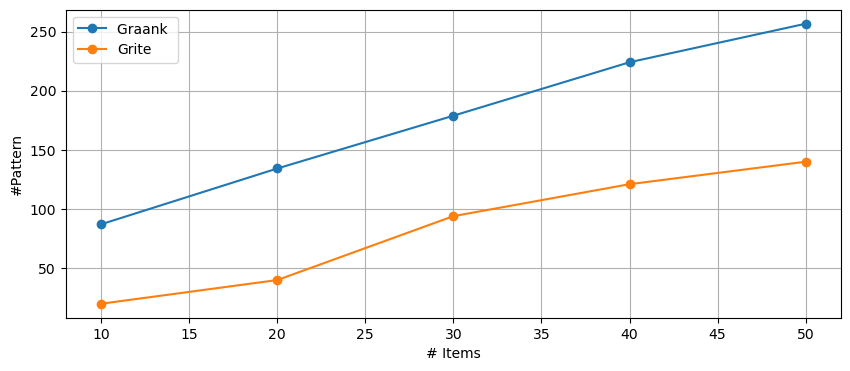

In [48]:
plt.figure(figsize=(10, 4))
plt.grid('--')
plt.xlabel("# Items")
plt.ylabel("#Pattern")
plt.xticks()
plt.xticks()
plt.plot(items2, nbr_p3,items2, nbr_p2, marker='o')
plt.legend(["Graank ","Grite"])
plt.show()

In [35]:
datasets = ['datasets/dataset.csv']
les_dataset = list(map(lambda x: pd.read_csv(x, sep=' '), datasets))
les_dataset[0]

,1,2,3,4,5,7,8,9,10,11
0,67108,522,257,736,5114,2151,1589,14,23,71
1,18676,620,325,817,6172,2450,1909,17,22,79
2,10051,746,390,858,8049,2053,1737,5,18,62
3,7091,529,291,780,5430,1695,1229,14,13,50
4,56857,542,312,1068,4620,1743,1104,7,15,46
...,...,...,...,...,...,...,...,...,...,...
195,25006,517,244,905,5107,2102,1469,21,23,129
196,35618,532,257,803,5310,2519,1887,20,13,153
197,41751,546,332,724,6628,2926,2535,11,21,171
198,29774,685,376,736,7940,2484,2191,23,24,235


In [34]:
elem = generatItemsetPatternGrite(les_dataset[0], 50)
len(elem)

20

In [36]:
datasets = ['datasets/dataset1.csv']
les_dataset = list(map(lambda x: pd.read_csv(x, sep=' '), datasets))
les_dataset[0]

,1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,67108,522,257,736,5114,2151,1589,14,23,71,49,82,409,515,915,1124,1694,298,351,514
1,18676,620,325,817,6172,2450,1909,17,22,79,47,88,450,654,1155,1410,1885,334,479,634
2,10051,746,390,858,8049,2053,1737,5,18,62,48,88,444,670,1174,1247,1555,278,421,629
3,7091,529,291,780,5430,1695,1229,14,13,50,34,70,326,512,887,803,1210,187,289,443
4,56857,542,312,1068,4620,1743,1104,7,15,46,31,75,266,437,764,702,1106,179,308,443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,25006,517,244,905,5107,2102,1469,21,23,129,31,57,339,434,878,854,1751,275,385,556
196,35618,532,257,803,5310,2519,1887,20,13,153,52,65,445,556,1184,1213,2005,321,481,671
197,41751,546,332,724,6628,2926,2535,11,21,171,63,118,549,902,1509,1386,2644,423,587,807
198,29774,685,376,736,7940,2484,2191,23,24,235,47,85,492,792,1545,1254,2552,319,497,801


In [37]:
elem = generatItemsetPatternGrite(les_dataset[0], 50)
len(elem)

40

In [50]:
datasets = ['datasets/dataset2.csv']
les_dataset = list(map(lambda x: pd.read_csv(x, sep=' '), datasets))
les_dataset[0]

,1,2,3,4,5,7,8,9,10,11
0,67108,522,257,736,5114,2151,1589,14,23,71
1,18676,620,325,817,6172,2450,1909,17,22,79
2,10051,746,390,858,8049,2053,1737,5,18,62
3,7091,529,291,780,5430,1695,1229,14,13,50
4,56857,542,312,1068,4620,1743,1104,7,15,46
...,...,...,...,...,...,...,...,...,...,...
295,36516,649,297,824,7065,4925,4704,62,69,428
296,36890,657,345,713,6971,4945,4346,61,43,438
297,33958,352,217,624,3658,3171,2605,48,25,222
298,4380,25,11,29,222,105,85,0,1,8


In [51]:
elem = generatItemsetPatternGrite(les_dataset[0], 50)
len(elem)

20

In [33]:
items3 = [10, 20, 30, 40, 50]
nbr_p3 = [30, 60, 110, 125, 165]
nbr_p4 = np.array([9143, 16426, 23227, 26481, 29958])/100
minsup = 50

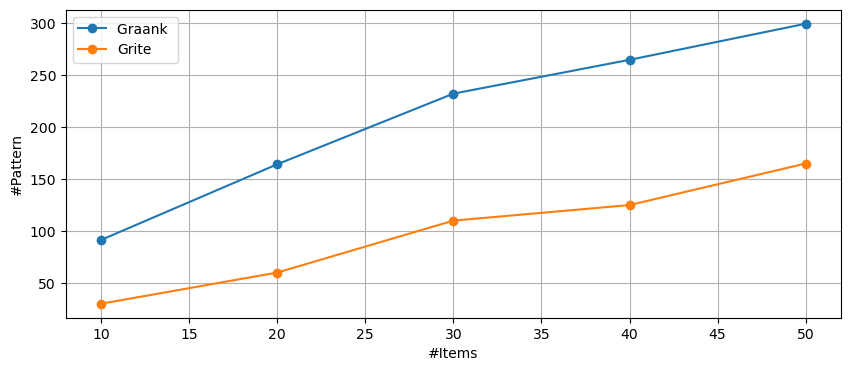

In [34]:
plt.figure(figsize=(10, 4))
plt.grid('--')
plt.xlabel("#Items")
plt.ylabel("#Pattern")
plt.xticks()
plt.yticks()
plt.plot(items3, nbr_p4,items3, nbr_p3, marker='o')
plt.legend(["Graank ","Grite"])
plt.show()

NameError: name 'minsup' is not defined

<Figure size 1200x400 with 0 Axes>

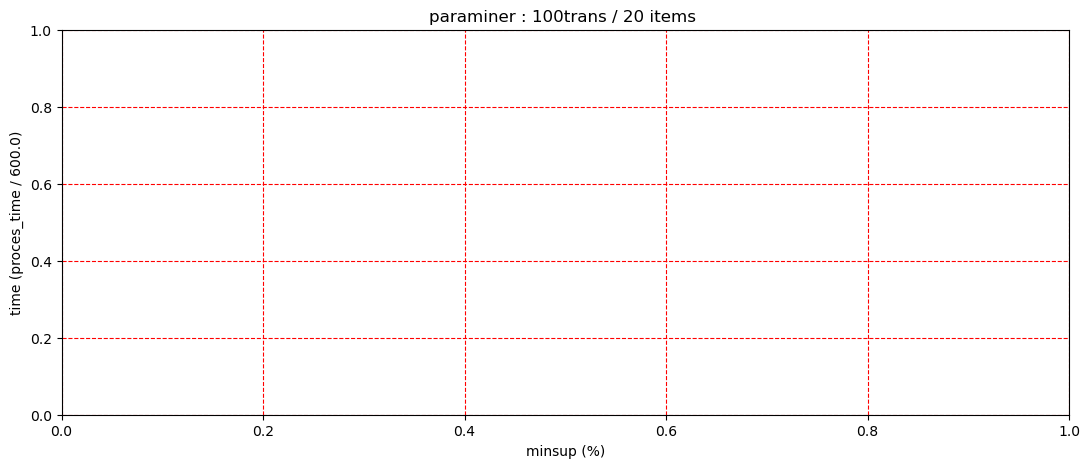

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
fig, ax1 = plt.subplots(figsize=(13, 5))
plt.grid(color='red', linestyle='--')
plt.title("")
plt.xlabel("# patterns")
plt.ylabel("Grite")

ax1.plot(minsup,sans_cond,minsup,with_cond)
plt.legend(["without condition","with condition"])
ax2 = ax1.twinx()
ax2.plot(minsup,ignore_pa, color="blue")
plt.ylabel('Graant')
plt.legend()
plt.show()

In [26]:
#in the X axis, we will display the number of pattern. in the both of Y-axis, we will display the minsup.
#in the Y-axis left, we will display the minsup of GRITE and for the right one, the GRAANK one